In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
import timeit
import re             # regular expression library
from wordcloud import WordCloud
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize
from collections import Counter
from collections import defaultdict

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models.coherencemodel import CoherenceModel

#from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split



In [2]:
pwd

'/Users/Robert/DSI/Capstone_3'

In [3]:
# Read datasets/papers.csv into papers
papers = pd.read_csv('nips-papers/papers.csv')


In [4]:
papers.head(3)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...


In [5]:
papers.tail(3)

,id,year,title,event_type,pdf_name,abstract,paper_text
7238,997,1994,A Real Time Clustering CMOS Neural Engine,NaN,997-a-real-time-clustering-cmos-neural-engine.pdf,Abstract Missing,A Real Time Clustering CMOS\nNeural Engine\nT....
7239,998,1994,Learning direction in global motion: two class...,NaN,998-learning-direction-in-global-motion-two-cl...,Abstract Missing,Learning direction in global motion: two\nclas...
7240,999,1994,Correlation and Interpolation Networks for Rea...,NaN,999-correlation-and-interpolation-networks-for...,Abstract Missing,Correlation and Interpolation Networks for\nRe...


In [6]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 7 columns):
id            7241 non-null int64
year          7241 non-null int64
title         7241 non-null object
event_type    2422 non-null object
pdf_name      7241 non-null object
abstract      7241 non-null object
paper_text    7241 non-null object
dtypes: int64(2), object(5)
memory usage: 396.1+ KB


In [7]:
drop_cols = ['id', 'event_type', 'pdf_name']
papers.drop(columns=drop_cols, axis=1, inplace=True)

In [8]:
def make_df_LDA_period(low, high):
    '''make a dataframe given upper and lower year bounds'''
 
    df = papers[(papers.year >= low) & (papers.year <= high)]
    df.reset_index(inplace=True)
    print('{0:4d} thru {1:4d} has{2:4d} rows'.format(low, high, len(df)))
          
    return df

In [9]:
papers_87_88 = make_df_LDA_period(1987, 1988)

papers_89_90 = make_df_LDA_period(1989, 1990)

papers_91_92 = make_df_LDA_period(1991, 1992)

papers_93_94 = make_df_LDA_period(1993, 1994)

papers_95_96 = make_df_LDA_period(1995, 1996)

papers_97_98 = make_df_LDA_period(1997, 1998)

papers_99_00 = make_df_LDA_period(1999, 2000)

papers_01_02 = make_df_LDA_period(2001, 2002)

papers_03_04 = make_df_LDA_period(2003, 2004)

papers_05_06 = make_df_LDA_period(2005, 2006)
papers_07_08 = make_df_LDA_period(2007, 2008)
papers_09_10 = make_df_LDA_period(2009, 2010)
papers_11_12 = make_df_LDA_period(2011, 2012)
papers_13_14 = make_df_LDA_period(2013, 2014)
papers_15_16 = make_df_LDA_period(2015, 2016)
papers_17 = make_df_LDA_period(2017, 2017)

1987 thru 1988 has 184 rows
1989 thru 1990 has 244 rows
1991 thru 1992 has 271 rows
1993 thru 1994 has 298 rows
1995 thru 1996 has 304 rows
1997 thru 1998 has 301 rows
1999 thru 2000 has 302 rows
2001 thru 2002 has 404 rows
2003 thru 2004 has 405 rows
2005 thru 2006 has 411 rows
2007 thru 2008 has 467 rows
2009 thru 2010 has 554 rows
2011 thru 2012 has 674 rows
2013 thru 2014 has 771 rows
2015 thru 2016 has 972 rows
2017 thru 2017 has 679 rows


In [11]:
all_df = [papers_87_88, 
papers_89_90, 
papers_91_92,
papers_93_94,
papers_95_96, 
papers_97_98, 
papers_99_00, 
papers_01_02, 
papers_03_04, 
papers_05_06, 
papers_07_08,
papers_09_10, 
papers_11_12, 
papers_13_14, 
papers_15_16, 
papers_17] 

In [33]:
count = 0
for d in all_df:
    count += len(d)
print(count)
len(all_df)

7241


16

In [13]:
papers_09_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 5 columns):
index         554 non-null int64
year          554 non-null int64
title         554 non-null object
abstract      554 non-null object
paper_text    554 non-null object
dtypes: int64(2), object(3)
memory usage: 21.7+ KB


# Preprocess text

In [15]:
# Use stopwords from "nltk.corpus"
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) # sets are efficient
stop_words.update(["this", "that", "thus", "from", "does", "example", "however", "since", "given", 
                    "et", "al", "hence", "therefore", "use", "used", "note", "corresponding", 
                    "setting", "well", "one", "form", "using", "second", "even", "known", "either",
                    "consider", "particular", "general", "represent", "case", "output", "defined",
                    "rather", "though", "although", "set", "problem", "function", "figure", "given",
                    "results", "number", "time", "data", "results", "given", "information", "different",
                    "models", "method", "n", "j", "r", "l", "mj", "a", "cj", "zero", "iv", "is", "elsewhere",
                    "large", "may", "finally", "c", "describing", "l", "cells", "single", "field",
                    "approximation", "activity", "mean", "input"])


In [16]:
%%time
# This function removes process the stopwords. Takes time, 3.5 mins
def rem_stopwords(txt):
    words = txt.split()
    ret_word = words.copy()
    for w in words: 
        if w.lower() in stop_words:
            ret_word.remove(w)
    return (" ".join(ret_word))

for df in all_df:
    df['text_processed'] = df['paper_text'].map(rem_stopwords)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 3min 33s, sys: 201 ms, total: 3min 33s
Wall time: 3min 33s


In [17]:
%%time
# This cell takes a long time, longer than 3 mins(seems slower)
# #Print the text of the first 3 rows 
# print(papers_thru_2000['paper_text'].head(3))

# Remove punctuation
for df in all_df:
    df['text_processed'] = df['text_processed'].map(lambda text: [w for w in word_tokenize(text.lower()) 
                      if w.isalpha()])
    df['text_string'] = [" ".join(map(str, l)) for l in df['text_processed']]
    # # Print the processed titles of the first rows 
    print(df.head(2))
    print()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


   index  year                                              title  \
0      0  1987  Self-Organization of Associative Database and ...   
1      1  1987  A Mean Field Theory of Layer IV of Visual Cort...   

           abstract                                         paper_text  \
0  Abstract Missing  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...   
1  Abstract Missing  683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...   

                                      text_processed  \
0  [associative, database, applications, hisashi,...   
1  [theory, layer, visual, cortex, application, a...   

                                         text_string  
0  associative database applications hisashi suzu...  
1  theory layer visual cortex application artific...  

   index  year                                              title  \
0    984  1989     Contour-Map Encoding of Shape for Early Vision   
1    995  1989  Neural Network Weight Matrix Synthesis Using O...   

           abstract       

   index  year                                              title  \
0   2899  2009                   Kernel Methods for Deep Learning   
1   2900  2009  Distribution-Calibrated Hierarchical Classific...   

                                            abstract  \
0  We introduce a new family of positive-definite...   
1  While many advances have already been made on ...   

                                          paper_text  \
0  Kernel Methods for Deep Learning\n\nYoungmin C...   
1  Distribution-Calibrated Hierarchical Classific...   

                                      text_processed  \
0  [kernel, methods, deep, learning, youngmin, ch...   
1  [hierarchical, classification, ofer, dekel, mi...   

                                         text_string  
0  kernel methods deep learning youngmin cho lawr...  
1  hierarchical classification ofer dekel microso...  

   index  year                                              title  \
0   3514  2011   A Non-Parametric Approach to Dyna

In [69]:
# %%time
# for df in all_df:
#     df['text_string'] = [" ".join(map(str, l)) for l in df['text_processed']]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 5.22 s, sys: 30.5 ms, total: 5.25 s
Wall time: 5.25 s


In [18]:
# # Use stopwords from "nltk.corpus"
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english')) # sets are efficient
STOPWORDS.update(["this", "that", "thus", "from", "does", "example", "however", "since", "given", 
                    "et", "al", "hence", "therefore", "use", "used", "note", "corresponding", 
                    "setting", "well", "one", "form", "using", "second", "even", "known", "either",
                    "consider", "particular", "general", "represent", "case", "output", "defined",
                    "rather", "though", "although", "set", "problem", "function", "figure", "given",
                    "results", "number", "time", "data", "results", "given", "information", "different",
                    "models", "method", "n", "j", "r", "l", "mj", "a", "cj", "zero", "iv", "is", "elsewhere",
                    "large", "may", "finally", "c", "describing", "l", "cells", "single", "field",
                    "approximation", "activity", "mean", "input", "x", "f", "here", "y", "means", "make", "say",
                    "that", "then", "good", "clarify", "b", "t", "layers", "s", "e", "units", "unit", "input", "h", 
                    "z", "p", "xt", "items", "player", "two", "item", "let", "d", "w", "ti", "m", "g", "local",
                    "q", "actions", "users", "system", "regret", "user", "xi", "rule",
                    "eq", "kl", "em", "v", "u", "first", "entries", "optimal", "error", "o", "result",
                    "see", "section", "update", "theorem", "variables", "rl", "st", "size", "based", "fig", "source",
                    "sources", "step", "o", "xi", "vi", "approach", "yt", "c", "new", "unit", "systems", "points", "point",
                    "test", "values", "value", "fi", "examples", "representation", "processing", "shown", "inputs", "initial",
                    "many", "problems", "speaker", "yi", "effect", "gp", "ya", "ylx", "algorithm", "pa", "ga"])
print(len(STOPWORDS))

340


In [19]:

def tokenize(text):
    return [token for token in text if token not in STOPWORDS]

In [26]:

def token_2(df):
    '''input df, returns tokenized text for that df'''
    paps = df.text_processed
    documents = paps.tolist()
    texts = []
    for doc in documents:
        texts.append(tokenize(doc))
    return(texts)

In [27]:
type(token_2)

function

In [88]:
texts_87_88_0 =  token_2(papers_87_88)
texts_89_90_0 =  token_2(papers_89_90) 
texts_91_92_0 =  token_2(papers_91_92)
texts_93_94_0 =  token_2(papers_93_94)
texts_95_96_0 =  token_2(papers_95_96) 
texts_97_98_0 =  token_2(papers_97_98) 

texts_99_00_0 =  token_2(papers_99_00) 
texts_01_02_0 =  token_2(papers_01_02) 
texts_03_04_0 =  token_2(papers_03_04) 

texts_05_06_0 =  token_2(papers_05_06) 
texts_07_08_0 =  token_2(papers_07_08)
texts_09_10_0 =  token_2(papers_09_10) 
texts_11_12_0 =  token_2(papers_11_12) 
texts_13_14_0 =  token_2(papers_13_14) 
texts_15_16_0 =  token_2(papers_15_16) 
texts_17_0 =  token_2(papers_17)

In [100]:
texts_01_02_0[1]

['generalizable',
 'relational',
 'binding',
 'distributed',
 'representations',
 'randall',
 'reilly',
 'department',
 'psychology',
 'university',
 'colorado',
 'boulder',
 'ucb',
 'boulder',
 'co',
 'richard',
 'busby',
 'department',
 'psychology',
 'university',
 'colorado',
 'boulder',
 'ucb',
 'boulder',
 'co',
 'oreilly',
 'abstract',
 'present',
 'model',
 'binding',
 'relationship',
 'spatial',
 'domain',
 'square',
 'triangle',
 'uses',
 'conjunctive',
 'representations',
 'instead',
 'popular',
 'temporal',
 'synchrony',
 'mechanisms',
 'supporters',
 'temporal',
 'synchrony',
 'argue',
 'conjunctive',
 'representations',
 'lack',
 'efficiency',
 'combinatorial',
 'numbers',
 'required',
 'systematicity',
 'resulting',
 'representations',
 'overly',
 'specific',
 'support',
 'generalization',
 'novel',
 'exemplars',
 'counter',
 'claims',
 'show',
 'model',
 'uses',
 'far',
 'fewer',
 'hidden',
 'conjunctions',
 'represented',
 'distributed',
 'representations',
 'broad',
 

In [132]:
def repl_networks(t):
    lis_of_lis = []
    for paper in t:
        words = [word.replace('networks','network') for word in paper]
        words = [word.replace('neurons','neuron') for word in paper]
        lis_of_lis.append(words)
    return (lis_of_lis)

In [133]:
texts_87_88 = repl_networks(texts_87_88_0)
texts_89_90 = repl_networks(texts_89_90_0) 
texts_91_92 = repl_networks(texts_91_92_0)
texts_93_94 = repl_networks(texts_93_94_0)
texts_95_96 = repl_networks(texts_95_96_0) 
texts_97_98 = repl_networks(texts_97_98_0) 

texts_99_00 = repl_networks(texts_99_00_0) 
texts_01_02 = repl_networks(texts_01_02_0) 
texts_03_04 = repl_networks(texts_03_04_0) 

texts_05_06 = repl_networks(texts_05_06_0) 
texts_07_08 = repl_networks(texts_07_08_0)
texts_09_10 = repl_networks(texts_09_10_0) 
texts_11_12 = repl_networks(texts_11_12_0) 
texts_13_14 = repl_networks(texts_13_14_0) 
texts_15_16 = repl_networks(texts_15_16_0) 
texts_17 = repl_networks(texts_17_0)

In [134]:
all_texts = [
texts_87_88, 
texts_89_90, 
texts_91_92,

texts_93_94,

texts_95_96, 
texts_97_98, 

texts_99_00, 
texts_01_02, 
texts_03_04, 

texts_05_06, 
texts_07_08,
texts_09_10, 
texts_11_12, 
texts_13_14, 
texts_15_16, 
texts_17] 
len(all_texts)

16

In [135]:
trg_sent = [['machine','learning','neural','network','dummy','neural','networks', "deep", "learning", "dum", "expert", "system", "expert","systems" ], 
            ['neural','networks', 'dummy','neural','network','machine','learning',"deep", "learning", "expert", "system", "expert","systems"]]
phrases = Phrases(trg_sent, min_count=1, threshold=1)
bigram = Phraser(phrases)
test_sent = ['machine','learning','neural','network','neural','networks', "deep", "learning", "expert", "system", "expert", "system"]
print(bigram[test_sent])

['machine_learning', 'neural_network', 'neural_networks', 'deep_learning', 'expert_system', 'expert_system']


In [149]:
# def corpus_1(texts):
#     corpus = []
#     for paper in texts:
#         bigram
#         corpus.append(bigram[paper])
#     return(corpus)
# spacy for lemmatization
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

In [150]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])
def corpus_1(texts):
    corpus = []
    for paper in texts:
        bigram
        corpus.append(bigram[paper])
    return(lemmatization(corpus))

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """see https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [151]:
corpus_87_88  = corpus_1(texts_87_88)
corpus_89_90  = corpus_1(texts_89_90)
corpus_91_92  = corpus_1(texts_91_92)
corpus_93_94  = corpus_1(texts_93_94)
corpus_95_96  = corpus_1(texts_95_96)
corpus_97_98  = corpus_1(texts_97_98)
corpus_99_00  = corpus_1(texts_99_00)
corpus_01_02  = corpus_1(texts_01_02)
corpus_03_04  = corpus_1(texts_03_04) 
corpus_05_06  = corpus_1(texts_05_06)
corpus_07_08  = corpus_1(texts_07_08)
corpus_09_10  = corpus_1(texts_09_10)
corpus_11_12  = corpus_1(texts_11_12)
corpus_13_14  = corpus_1(texts_13_14)
corpus_15_16  = corpus_1(texts_15_16)
corpus_17  = corpus_1(texts_17)

In [152]:
def bow_LDA_topics(corpus):
    frequency = defaultdict(int)
    for text in corpus:
        for token in text:
            frequency[token] += 1
    texts_2 = [[token for token in text if frequency[token] > 10] for text in corpus]
    return(texts_2)
    

In [153]:
texts_2_87_88  = bow_LDA_topics(corpus_87_88)
texts_2_89_90  = bow_LDA_topics(corpus_89_90)
texts_2_91_92  = bow_LDA_topics(corpus_91_92)

texts_2_93_94  = bow_LDA_topics(corpus_93_94)

texts_2_95_96  = bow_LDA_topics(corpus_95_96)
texts_2_97_98  = bow_LDA_topics(corpus_97_98)

texts_2_99_00  = bow_LDA_topics(corpus_99_00)
texts_2_01_02  = bow_LDA_topics(corpus_01_02)
texts_2_03_04  = bow_LDA_topics(corpus_03_04) 

texts_2_05_06  = bow_LDA_topics(corpus_05_06)
texts_2_07_08  = bow_LDA_topics(corpus_07_08)
texts_2_09_10  = bow_LDA_topics(corpus_09_10)
texts_2_11_12  = bow_LDA_topics(corpus_11_12)
texts_2_13_14  = bow_LDA_topics(corpus_13_14)
texts_2_15_16  = bow_LDA_topics(corpus_15_16)
texts_2_17  = bow_LDA_topics(corpus_17)                             

In [154]:
def build_corpora(texts_2):
    '''returns dictionary and corpus'''
    dictionary = corpora.Dictionary(texts_2)
    corpus_test = []
    for text in texts_2:
        corpus_test.append(dictionary.doc2bow(text))
    return(dictionary, corpus_test)

In [155]:
texts_2_87_88[:1]

[['associative',
  'associative',
  'database',
  'propose',
  'together',
  'application',
  'robot',
  'propose',
  'database',
  'associate',
  'half',
  'part',
  'discussion',
  'propose',
  'aspect',
  'hardware',
  'produce',
  'style',
  'latter',
  'part',
  'letter',
  'robot',
  'demonstrate',
  'introduction',
  'mapping',
  'finite',
  'infinite',
  'finite',
  'infinite',
  'learning',
  'machine',
  'observe',
  'pair',
  'sample',
  'randomly',
  'product',
  'compute',
  'estimate',
  'small',
  'estimation',
  'measure',
  'usually',
  'fast',
  'decrease',
  'estimation',
  'increase',
  'sample',
  'well',
  'learn',
  'machine',
  'expression',
  'performance',
  'lack',
  'consideration',
  'candidate',
  'assume',
  'find',
  'learn',
  'machine',
  'discuss',
  'type',
  'learn',
  'machine',
  'advance',
  'understand',
  'associative',
  'database',
  'parameter',
  'type',
  'ordinary',
  'type',
  'learn',
  'machine',
  'assume',
  'equation',
  'relate',
 

In [156]:
dict_87_88 , corp_87_88  = build_corpora(texts_2_87_88)
dict_89_90 , corp_89_90  = build_corpora(texts_2_89_90)
dict_91_92 , corp_91_92  = build_corpora(texts_2_91_92)

dict_93_94 , corp_93_94  = build_corpora(texts_2_93_94)

dict_95_96 , corp_95_96  = build_corpora(texts_2_95_96)
dict_97_98 , corp_97_98  = build_corpora(texts_2_97_98)

dict_99_00 , corp_99_00  = build_corpora(texts_2_99_00)
dict_01_02 , corp_01_02  = build_corpora(texts_2_01_02)
dict_03_04 , corp_03_04  = build_corpora(texts_2_03_04) 

dict_05_06 , corp_05_06  = build_corpora(texts_2_05_06)
dict_07_08 , corp_07_08  = build_corpora(texts_2_07_08)
dict_09_10 , corp_09_10  = build_corpora(texts_2_09_10)
dict_11_12 , corp_11_12  = build_corpora(texts_2_11_12)
dict_13_14 , corp_13_14  = build_corpora(texts_2_13_14)
dict_15_16 , corp_15_16  = build_corpora(texts_2_15_16)
dict_17 , corp_17  = build_corpora(texts_2_17)

In [158]:
pwd

'/Users/Robert/DSI/Capstone_3'

In [159]:
# Building LDA Mallet Model

mallet_path = '/Users/Robert/DSI/Capstone_3/mallet-2.0.8/bin/mallet' # update this path
ldamallet_87_88 = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corp_87_88, 
                                             num_topics=20, 
                                             id2word=dict_87_88)

In [160]:
# Show Topics
print("****************   Papers 1987 thru 1988   ***********************************************")
pprint(ldamallet_87_88.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet_87_88 = CoherenceModel(model=ldamallet_87_88,
                                                 texts=texts_2_87_88, 
                                                 dictionary=dict_87_88, 
                                                 coherence='c_v')
coherence_ldamallet_87_88 = coherence_model_ldamallet_87_88.get_coherence()

print('\nCoherence Score: ', coherence_ldamallet_87_88)

****************   Papers 1987 thru 1988   ***********************************************
[(4,
  [('network', 0.05820770519262981),
   ('equation', 0.027498604131769962),
   ('delay', 0.02386934673366834),
   ('stable', 0.022892238972640984),
   ('oscillation', 0.01786711334450028),
   ('stability', 0.017587939698492462),
   ('attractor', 0.01605248464544947),
   ('matrix', 0.014935790061418201),
   ('fix', 0.014377442769402568),
   ('dynamic', 0.014377442769402568)]),
 (15,
  [('map', 0.03157139440325281),
   ('image', 0.026070318105716337),
   ('orientation', 0.01901458981104999),
   ('region', 0.014231045204496532),
   ('surface', 0.013035159052858169),
   ('space', 0.012317627361875149),
   ('visual', 0.012078450131547477),
   ('object', 0.01195886151638364),
   ('process', 0.011719684286055968),
   ('center', 0.011480507055728294)]),
 (3,
  [('model', 0.06749928496520163),
   ('simulation', 0.027075984364572408),
   ('potential', 0.02030698827342931),
   ('level', 0.0160167794832

In [163]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corp_87_88, 
                                                 num_topics=num_topics, 
                                                 id2word=dict_87_88)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts_2_87_88, 
                                        dictionary=dict_87_88, 
                                        coherence='c_v')
        
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [164]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_87_88, 
                                                        corpus=corp_87_88, 
                                                        texts=texts_2_87_88, 
                                                        start=2, limit=40, step=6)

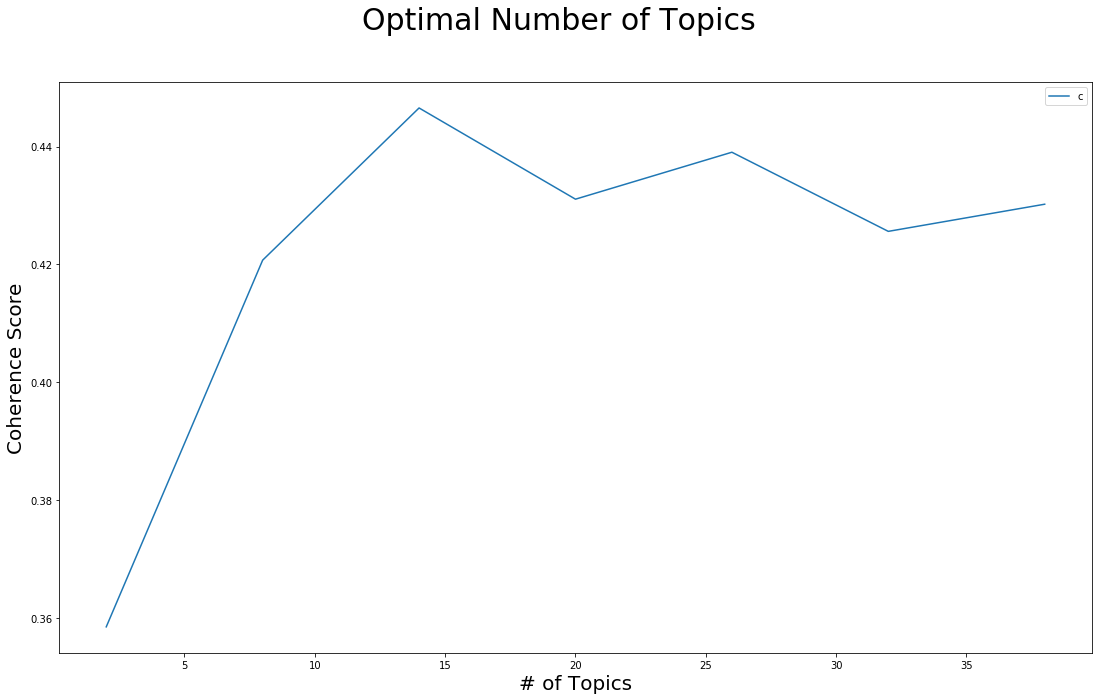

In [200]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
fig = plt.gcf()
fig.set_size_inches(18, 9)
fig.suptitle('Optimal Number of Topics', fontsize = 30)
plt.xlabel("# of Topics", fontsize = 20)
plt.ylabel("Coherence Score", fontsize = 20)
plt.legend(("coherence_values"), loc='best', fontsize = 10)
plt.show()


In [208]:
# fit gensim's LDA model 1987 - 1988 documents
# the number of topics should be optimized iteratively
n_topics = 20
topics_87_88 = LdaModel(corpus=corp_87_88,
                           id2word=dict_87_88,
                           num_topics=n_topics,
                           passes=10)

In [209]:
# print out first n topics
for i, topic in enumerate(topics_87_88.print_topics(n_topics)):
    pprint("{} --- {}".format(i, topic))
    print()

('0 --- (0, \'0.015*"signal" + 0.012*"region" + 0.010*"classifier" + '
 '0.010*"training" + 0.009*"decision" + 0.008*"performance" + 0.008*"neural" + '
 '0.008*"train" + 0.007*"noise" + 0.007*"receiver"\')')

('1 --- (1, \'0.022*"state" + 0.020*"net" + 0.015*"vector" + 0.015*"learn" + '
 '0.014*"speech" + 0.014*"network" + 0.011*"code" + 0.009*"dynamic" + '
 '0.009*"weight" + 0.009*"performance"\')')

('2 --- (2, \'0.024*"symbol" + 0.020*"memory" + 0.016*"model" + 0.015*"ghost" '
 '+ 0.014*"pattern" + 0.011*"inhibitory" + 0.010*"map" + 0.010*"receptive" + '
 '0.010*"equation" + 0.010*"scheme"\')')

('3 --- (3, \'0.025*"charge" + 0.024*"weight" + 0.014*"transfer" + '
 '0.013*"implant" + 0.012*"model" + 0.012*"storage" + 0.011*"transistor" + '
 '0.010*"change" + 0.010*"neural_network" + 0.010*"signal"\')')

('4 --- (4, \'0.015*"role" + 0.013*"network" + 0.012*"structure" + '
 '0.012*"image" + 0.010*"pattern" + 0.008*"color" + 0.008*"learn" + '
 '0.008*"distribute" + 0.007*"vector" + 0.00

In [210]:
# Takes some time, depends how many papers
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(topics_87_88, corp_87_88, dict_87_88)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [73]:
# # #____________________________________________________________________________________________________________
# # #____________________________________________________________________________________________________________
# fit gensim's LDA model
# the number of topics should be optimized iteratively
topics_89_90 = LdaModel(corpus=corp_89_90,
                           id2word=dict_89_90,
                           num_topics=15,
                           passes=10)

# # #____________________________________________________________________________________________________________


# print out first 10 topics
for i, topic in enumerate(topics_89_90.print_topics(15)):
    pprint("{} --- {}".format(i, topic))
    print()

# # #____________________________________________________________________________________________________________

# Takes about 5-10 minutes, depends how many papers
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(topics_89_90, corp_89_90, dict_89_90)
pyLDAvis.display(vis_data)

('0 --- (0, \'0.011*"weight" + 0.011*"network" + 0.008*"memory" + '
 '0.008*"learning" + 0.006*"neuron" + 0.006*"neural" + 0.005*"cluster" + '
 '0.005*"training" + 0.005*"current" + 0.005*"parameters"\')')

('1 --- (1, \'0.018*"chain" + 0.017*"region" + 0.013*"mouse" + 0.012*"network" '
 '+ 0.011*"lateral" + 0.011*"human" + 0.010*"ig" + 0.009*"precursor" + '
 '0.008*"networks" + 0.008*"connections"\')')

('2 --- (2, \'0.021*"learning" + 0.017*"network" + 0.016*"training" + '
 '0.010*"weights" + 0.010*"hidden" + 0.008*"networks" + 0.006*"generalization" '
 '+ 0.005*"functions" + 0.005*"performance" + 0.004*"weight"\')')

('3 --- (3, \'0.018*"network" + 0.016*"image" + 0.009*"object" + '
 '0.007*"features" + 0.007*"training" + 0.007*"images" + 0.006*"networks" + '
 '0.005*"feature" + 0.005*"weights" + 0.005*"layer"\')')

('4 --- (4, \'0.015*"neurons" + 0.014*"model" + 0.009*"neuron" + '
 '0.008*"network" + 0.008*"cell" + 0.008*"cortex" + 0.007*"response" + '
 '0.006*"firing" + 0.006*"syn

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [69]:
# fit gensim's LDA model
# the number of topics should be optimized iteratively
topics_89_90 = LdaModel(corpus=corp_89_90,
                           id2word=dict_89_90,
                           num_topics=15,
                           passes=10)

# # #____________________________________________________________________________________________________________


# print out first 10 topics
for i, topic in enumerate(topics_89_90.print_topics(15)):
    pprint("{} --- {}".format(i, topic))
    print()

# # #____________________________________________________________________________________________________________

# Takes about 5-10 minutes, depends how many papers
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(topics_89_90, corp_89_90, dict_89_90)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
